PERFORMANCE ANALYSIS (CONTACT CENTER)

In [63]:
### LIBRARIES:

import pandas as pd
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
### DATA SOURCE

# Define the URL (On GitHub repository)
url = "https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/CC_TEST.csv"

# Read the CSV file
df = pd.read_csv(url)

In [3]:
df.columns

Index(['Fecha', 'Intervalo', 'Forecast Ordenes', 'Ordenes', '% Desv Ordenes',
       'Dif Ordenes', 'Cancelados', '% SS Cancelados', 'Forecast % CR',
       'Contact Rate', '% Desv. CR', 'Forecast', 'Inflow', '% Desvi. Inglow',
       'Diff. Inflow', 'Cierres', 'Asignados', '% Sla Forecast', '% SLA',
       '% Desv SLA', 'QFRT (Min) Forecast', '#QFRT (Min)', '% Desv QFRT',
       'RT (Min)', 'AHT (min) Forecast', 'AHT (Min)',
       'TFRT (Total first response time)', 'AWT (Tiempo Medio de Espera)',
       'CWD (Closing wait done)', 'SAT (support assignation time)',
       'CWT (Close wainting time)', '% Muestras', '% Survey_rate',
       '% answer_rate', 'Csat_Gral', 'Enc.Enviadas Gral',
       'Enc. Realizadas Comp', 'Enc. Positivas Comp', 'Enc. Negativo Comp',
       'Enc. Neutros Comp', '% Dsat comp', 'Enc. Contestadas Only comp',
       'Enc. Dsat Only Comp', '% Dsat Only Agent',
       'Enc. Contestadas Partial comp', 'Enc. Dsat Partial comp',
       '% Dsat Partial Automated', '

In [4]:
df.head(5)

,Fecha,Intervalo,Forecast Ordenes,Ordenes,% Desv Ordenes,Dif Ordenes,Cancelados,% SS Cancelados,Forecast % CR,Contact Rate,...,Dentro Sla,Fuera Sla,Sin FRT,%FRT_Vacio,Horas Requeridas,Horas Conexion,PD general,PD Agente,HC Requerido,- HC Real
0,2024-11-25 00:00:00,1899-12-30 00:00:00,3051,2625,"-13,96 %",-426,279,"10,63 %","0,71 %","6,36 %",...,147,20,1,"0,60 %",20.207907,40.841389,"7,23",6.455864,40.415814,80
1,2024-11-25 00:00:00,1899-12-30 00:30:00,2506,2086,"-16,77 %",-420,290,"13,90 %","0,61 %","6,90 %",...,116,28,1,"0,69 %",14.411157,37.493056,"7,04",5.928637,28.822315,59
2,2024-11-25 00:00:00,1899-12-30 01:00:00,1798,1327,"-26,19 %",-471,165,"12,43 %","0,67 %","9,87 %",...,103,28,2,"1,53 %",13.029349,31.071667,"6,83",6.209021,26.058697,57
3,2024-11-25 00:00:00,1899-12-30 01:30:00,1471,992,"-32,57 %",-479,129,"13,00 %","0,55 %","8,17 %",...,72,9,2,"2,47 %",9.424829,31.894167,"3,94",3.661363,18.849658,48
4,2024-11-25 00:00:00,1899-12-30 02:00:00,1090,698,"-35,94 %",-392,90,"12,89 %","0,55 %","6,59 %",...,44,2,2,"4,35 %",8.058198,27.282222,"3,07",2.252976,16.116395,46


In [5]:
### QUALITY REPORT (PRE CLEANING)

def create_data_quality_report(df):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df)
    
    for column in df.columns:
        # Count missing values
        missing_count = df[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            zero_count = (df[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df = quality_df.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df

# Create the quality report
quality_report = create_data_quality_report(df)

selected_columns = ['% SLA', 'Csat_Gral', 'AHT (Min)']
Q_Report = quality_report[quality_report['Column_Name'].isin(selected_columns)]
Q_Report

,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
34,Csat_Gral,float64,672,0,0.0,0,0.0,0,0.0,539
18,% SLA,object,672,0,0.0,0,0.0,0,0.0,542
25,AHT (Min),float64,672,0,0.0,0,0.0,0,0.0,672


In [6]:
### DATA CLEANING AND TRANSFORMATION

# Create a copy of the original dataframe
df_cleaned = df.copy()

# Define columns where ',' should be replaced with '.'
columns_with_commas = [col for col in df_cleaned.columns 
                      if df_cleaned[col].astype(str).str.contains(',').any()]

# Replace ',' with '.' in specified columns
for col in columns_with_commas:
    df_cleaned[col] = (df_cleaned[col].astype(str)
                                    .str.replace(',', '.')
                                    .str.replace('%', '')
                                    .str.strip()
                                    .astype(float)
                                    .round(2))

# Convert date and time columns
df_cleaned['Fecha'] = pd.to_datetime(df_cleaned['Fecha'])
df_cleaned['Intervalo'] = pd.to_datetime(df_cleaned['Intervalo']).dt.time

# Round numeric columns to 2 decimal places
columns_to_round = [
    "QFRT (Min) Forecast", "#QFRT (Min)", "RT (Min)", "AHT (min) Forecast",
    "AHT (Min)", "TFRT (Total first response time)", "AWT (Tiempo Medio de Espera)",
    "CWD (Closing wait done)", "SAT (support assignation time)",
    "CWT (Close wainting time)", "Csat_Gral", "Horas Requeridas",
    "Horas Conexion", "PD Agente", "HC Requerido"
]

for col in columns_to_round:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].round(2)

# Rename columns
df_cleaned = df_cleaned.rename(columns={
    '- HC Real': 'HC Real',
    'AWT (Tiempo Medio de Espera)': 'AWT',
    'CWT (Close wainting time)': 'CWT',
    'SAT (support assignation time)': 'SAT'
})

# Add week-related columns
df_cleaned['Start of Week'] = df_cleaned['Fecha'].dt.to_period('W-SAT').dt.start_time
df_cleaned['Day of Week'] = df_cleaned['Fecha'].dt.dayofweek

# Create Day Name column
day_mapping = {
    0: '1-Monday',
    1: '2-Tuesday',
    2: '3-Wednesday',
    3: '4-Thursday',
    4: '5-Friday',
    5: '6-Saturday',
    6: '0-Sunday'
}
df_cleaned['Day Name'] = df_cleaned['Day of Week'].map(day_mapping)

# Create Datetime column
df_cleaned['Datetime'] = pd.to_datetime(df_cleaned['Fecha'].astype(str) + ' ' + 
                                      df_cleaned['Intervalo'].astype(str))

# Convert specific columns to numeric
numeric_columns = ['Enc. Contestadas full_automated comp', '% Dsat full Automated Comp']
for col in numeric_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')



In [7]:
### NEW COLUMNS

### %CSAT SCORE
Promoters = df_cleaned['Enc. Positivas Comp'].fillna(0) + df_cleaned['Enc. Neutros Comp'].fillna(0)
Detractors = df_cleaned['Enc. Negativo Comp'].fillna(0)
Surveys = df_cleaned['Enc. Realizadas Comp'].fillna(0)

df_cleaned['CSAT_SCORE'] = np.where(Surveys > 0, round(Promoters / Surveys*100,1), 0)




In [8]:
### QUALITY REPORT (POST-CLEANING)

def create_data_quality_report(df_cleaned):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df_cleaned)
    
    for column in df_cleaned.columns:
        # Count missing values
        missing_count = df_cleaned[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df_cleaned[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df_cleaned[column]):
            zero_count = (df_cleaned[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df_cleaned[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df_cleaned[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df_cleaned = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df_cleaned = quality_df_cleaned.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df_cleaned

# Create the quality report
quality_report = create_data_quality_report(df_cleaned)


quality_report[quality_report['Column_Name'].isin(['Csat_Gral','CSAT_SCORE', 'AHT (Min)', '% SLA', 'Enc. Positivas Comp', 'Enc. Neutros Comp','Enc. Negativo Comp','Enc. Realizadas Comp'])]


,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
39,Enc. Neutros Comp,float64,672,107,15.92,0,0.0,0,0.00,24
37,Enc. Positivas Comp,float64,672,5,0.74,0,0.0,0,0.00,96
38,Enc. Negativo Comp,int64,672,0,0.00,0,0.0,0,0.00,151
36,Enc. Realizadas Comp,int64,672,0,0.00,0,0.0,0,0.00,225
18,% SLA,float64,672,0,0.00,0,0.0,0,0.00,542
34,Csat_Gral,float64,672,0,0.00,0,0.0,0,0.00,165
25,AHT (Min),float64,672,0,0.00,0,0.0,0,0.00,371
71,CSAT_SCORE,float64,672,0,0.00,0,0.0,5,0.74,255


In [9]:
### CLEANED AND TRANSFORMED DATA

# Display the first few rows of the cleaned dataset
data = df_cleaned   ###RENAMED DATAFRAME
data.head(5)

,Fecha,Intervalo,Forecast Ordenes,Ordenes,% Desv Ordenes,Dif Ordenes,Cancelados,% SS Cancelados,Forecast % CR,Contact Rate,...,Horas Conexion,PD general,PD Agente,HC Requerido,HC Real,Start of Week,Day of Week,Day Name,Datetime,CSAT_SCORE
0,2024-11-25,00:00:00,3051,2625,-13.96,-426,279,10.63,0.71,6.36,...,40.84,7.23,6.46,40.42,80,2024-11-24,0,1-Monday,2024-11-25 00:00:00,50.0
1,2024-11-25,00:30:00,2506,2086,-16.77,-420,290,13.90,0.61,6.90,...,37.49,7.04,5.93,28.82,59,2024-11-24,0,1-Monday,2024-11-25 00:30:00,38.9
2,2024-11-25,01:00:00,1798,1327,-26.19,-471,165,12.43,0.67,9.87,...,31.07,6.83,6.21,26.06,57,2024-11-24,0,1-Monday,2024-11-25 01:00:00,38.9
3,2024-11-25,01:30:00,1471,992,-32.57,-479,129,13.00,0.55,8.17,...,31.89,3.94,3.66,18.85,48,2024-11-24,0,1-Monday,2024-11-25 01:30:00,40.6
4,2024-11-25,02:00:00,1090,698,-35.94,-392,90,12.89,0.55,6.59,...,27.28,3.07,2.25,16.12,46,2024-11-24,0,1-Monday,2024-11-25 02:00:00,35.3


In [10]:
data.columns

Index(['Fecha', 'Intervalo', 'Forecast Ordenes', 'Ordenes', '% Desv Ordenes',
       'Dif Ordenes', 'Cancelados', '% SS Cancelados', 'Forecast % CR',
       'Contact Rate', '% Desv. CR', 'Forecast', 'Inflow', '% Desvi. Inglow',
       'Diff. Inflow', 'Cierres', 'Asignados', '% Sla Forecast', '% SLA',
       '% Desv SLA', 'QFRT (Min) Forecast', '#QFRT (Min)', '% Desv QFRT',
       'RT (Min)', 'AHT (min) Forecast', 'AHT (Min)',
       'TFRT (Total first response time)', 'AWT', 'CWD (Closing wait done)',
       'SAT', 'CWT', '% Muestras', '% Survey_rate', '% answer_rate',
       'Csat_Gral', 'Enc.Enviadas Gral', 'Enc. Realizadas Comp',
       'Enc. Positivas Comp', 'Enc. Negativo Comp', 'Enc. Neutros Comp',
       '% Dsat comp', 'Enc. Contestadas Only comp', 'Enc. Dsat Only Comp',
       '% Dsat Only Agent', 'Enc. Contestadas Partial comp',
       'Enc. Dsat Partial comp', '% Dsat Partial Automated',
       'Enc. Contestadas full_automated comp', 'Enc. Dsat Full Automated Comp',
       '%

EXPLORATORY DATA ANALYSIS (EDA) FOR CSAT RATING, CSAT SCORE, SLA and AHT

In [11]:
### CALCULO DE ENCUESTAS REQUERIDAS COMO RESPUESTA

# Calculate totals
total_enviadas = data['Enc.Enviadas Gral'].sum()
total_realizadas = data['Enc. Realizadas Comp'].sum()

# Sample size calculation parameters
margin_error = 0.05     # 5% margin of error
z_score = 1.96         # z-score for 95% confidence

# Calculate required sample size
numerator = (z_score**2 * 0.5 * 0.5 * total_enviadas)
denominator = (margin_error**2 * (total_enviadas - 1) + z_score**2 * 0.5 * 0.5)
required_surveys = math.ceil(numerator / denominator)

# Calculate actual confidence level based on completed surveys
if total_realizadas > 0 and total_enviadas > 0:
    # Calculate standard error
    std_error = math.sqrt((0.5 * 0.5) / total_realizadas * (total_enviadas - total_realizadas)/(total_enviadas - 1))
    
    # Calculate actual margin of error
    actual_margin = std_error * z_score
    
    # Calculate confidence level
    confidence_level = (1 - 2 * (1 - stats.norm.cdf(total_realizadas, required_surveys, std_error))) * 100
else:
    confidence_level = 0

# Calculate completion percentage
completion_percentage = (total_realizadas / total_enviadas * 100) if total_enviadas > 0 else 0

# Check if completed surveys are sufficient
is_sufficient = total_realizadas >= required_surveys

print(f"Total population (surveys sent): {total_enviadas}")
print(f"Required sample size: {required_surveys}")
print(f"Completed surveys: {total_realizadas}")
print(f"Completion rate: {completion_percentage:.2f}%")
print(f"Confidence level achieved: {confidence_level:.2f}%")
print(f"Status: {'Sufficient' if is_sufficient else 'Insufficient'}")

if not is_sufficient:
    print(f"Additional surveys needed: {required_surveys - total_realizadas}")

Total population (surveys sent): 175933
Required sample size: 384
Completed surveys: 63796
Completion rate: 36.26%
Confidence level achieved: 100.00%
Status: Sufficient


Basic Statistics:
count    672.000000
mean       2.450610
std        0.386926
min        1.000000
25%        2.257500
50%        2.420000
75%        2.620000
max        4.500000
Name: Csat_Gral, dtype: float64

Additional Statistics:
Skewness: 0.35269526778635313
Kurtosis: 3.0930488230209643


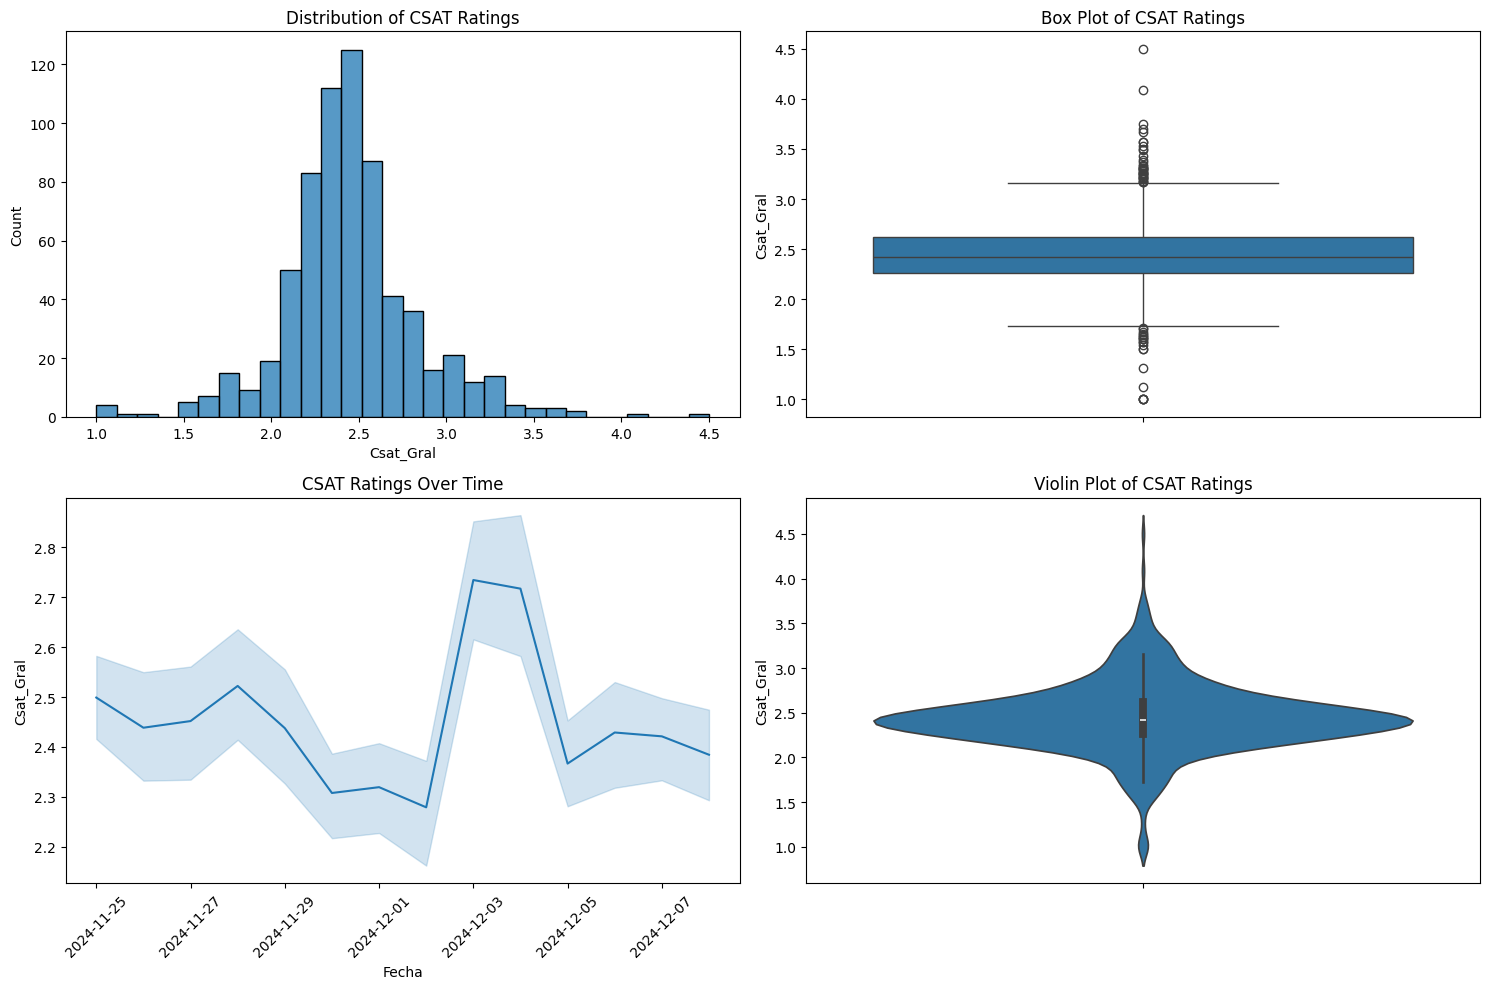


Missing Values:
Count: 0
Percentage: 0.0 %

Top 5 Most Common Values:
Csat_Gral
2.50    20
2.38    18
2.44    17
2.36    13
2.37    13
Name: count, dtype: int64


In [12]:
### CSAT RATING

# Basic statistics
print("Basic Statistics:")
print(data["Csat_Gral"].describe())

# Additional statistics
print("\nAdditional Statistics:")
print("Skewness:", data["Csat_Gral"].skew())
print("Kurtosis:", data["Csat_Gral"].kurtosis())

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Histogram
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="Csat_Gral", bins=30)
plt.title("Distribution of CSAT Ratings")

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=data["Csat_Gral"])
plt.title("Box Plot of CSAT Ratings")

# Time series plot (assuming you have a date column)
plt.subplot(2, 2, 3)
sns.lineplot(data=data, x="Fecha", y="Csat_Gral")
plt.title("CSAT Ratings Over Time")
plt.xticks(rotation=45)

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=data["Csat_Gral"])
plt.title("Violin Plot of CSAT Ratings")

plt.tight_layout()
plt.show()

# Missing values analysis
print("\nMissing Values:")
print("Count:", data["Csat_Gral"].isnull().sum())
print("Percentage:", (data["Csat_Gral"].isnull().sum() / len(data)) * 100, "%")

# Value counts (top 5)
print("\nTop 5 Most Common Values:")
print(data["Csat_Gral"].value_counts().head())

Basic Statistics:
count    672.000000
mean      39.108333
std       10.285337
min        0.000000
25%       34.100000
50%       38.600000
75%       43.525000
max       90.000000
Name: CSAT_SCORE, dtype: float64

Additional Statistics:
Skewness: 0.14616495435457347
Kurtosis: 2.9044305205398113


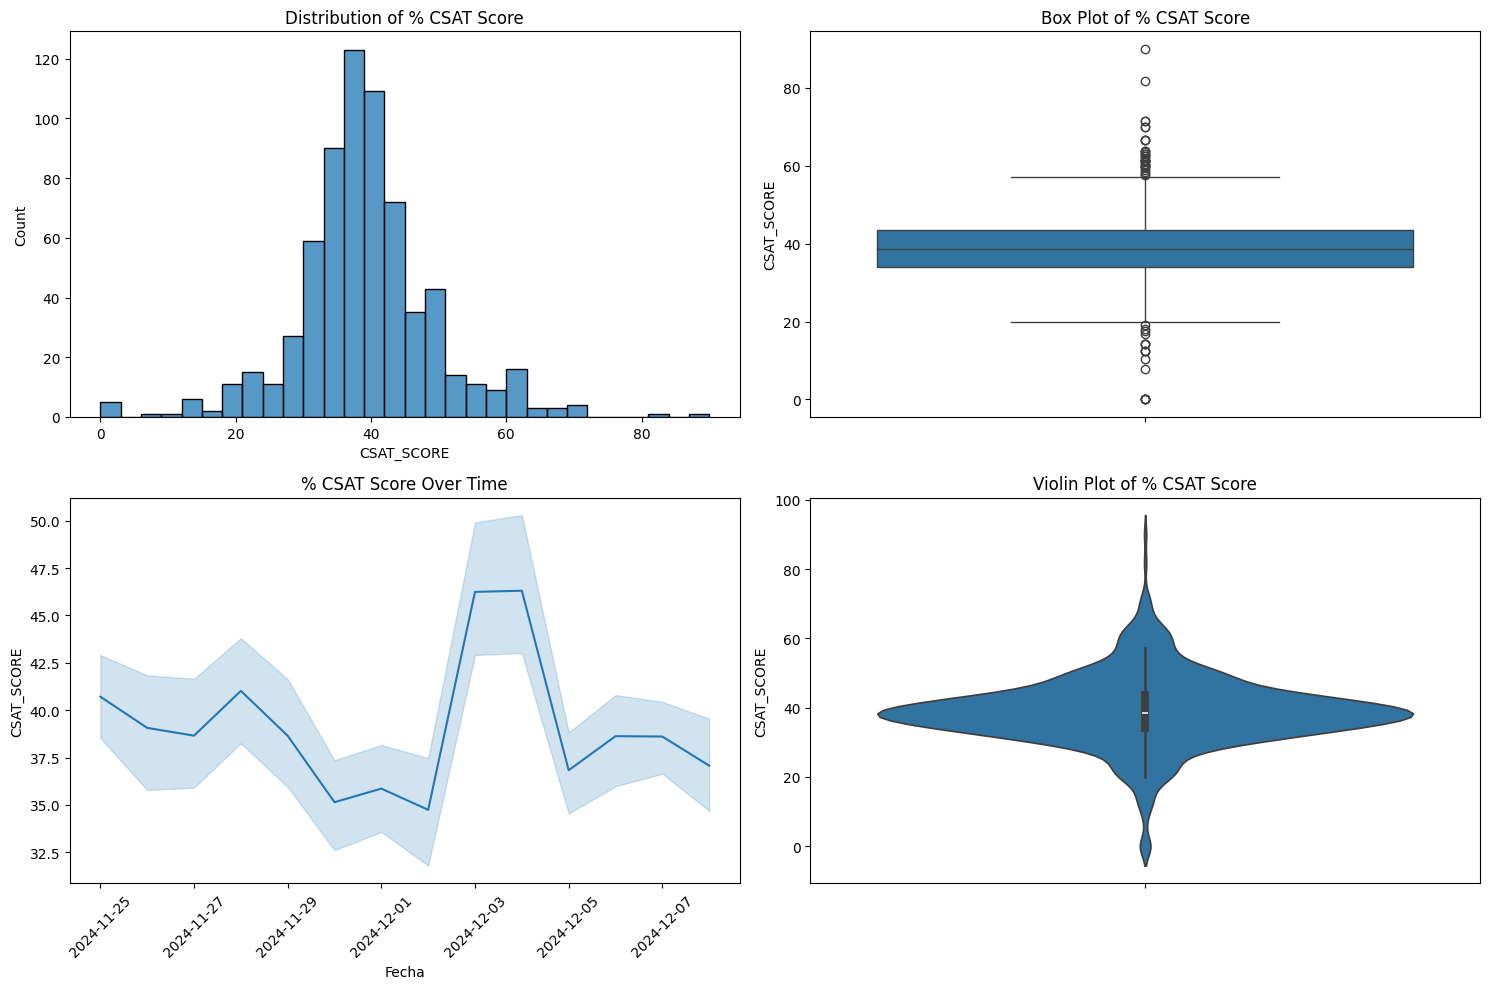


Missing Values:
Count: 0
Percentage: 0.0 %

Top 5 Most Common Values:
CSAT_SCORE
50.0    26
37.5    16
40.0    14
33.3    13
25.0     9
Name: count, dtype: int64


In [13]:
### CSAT SCORE

# Basic statistics
print("Basic Statistics:")
print(data["CSAT_SCORE"].describe())

# Additional statistics
print("\nAdditional Statistics:")
print("Skewness:", data["CSAT_SCORE"].skew())
print("Kurtosis:", data["CSAT_SCORE"].kurtosis())

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Histogram
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="CSAT_SCORE", bins=30)
plt.title("Distribution of % CSAT Score")

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=data["CSAT_SCORE"])
plt.title("Box Plot of % CSAT Score")

# Time series plot (assuming you have a date column)
plt.subplot(2, 2, 3)
sns.lineplot(data=data, x="Fecha", y="CSAT_SCORE")
plt.title("% CSAT Score Over Time")
plt.xticks(rotation=45)

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=data["CSAT_SCORE"])
plt.title("Violin Plot of % CSAT Score")

plt.tight_layout()
plt.show()

# Missing values analysis
print("\nMissing Values:")
print("Count:", data["CSAT_SCORE"].isnull().sum())
print("Percentage:", (data["CSAT_SCORE"].isnull().sum() / len(data)) * 100, "%")

# Value counts (top 5)
print("\nTop 5 Most Common Values:")
print(data["CSAT_SCORE"].value_counts().head())

Basic Statistics:
count    672.000000
mean      80.135521
std       16.344614
min        7.170000
25%       77.742500
50%       85.175000
75%       89.470000
max      100.000000
Name: % SLA, dtype: float64

Additional Statistics:
Skewness: -2.3523713304259664
Kurtosis: 6.405565651595216


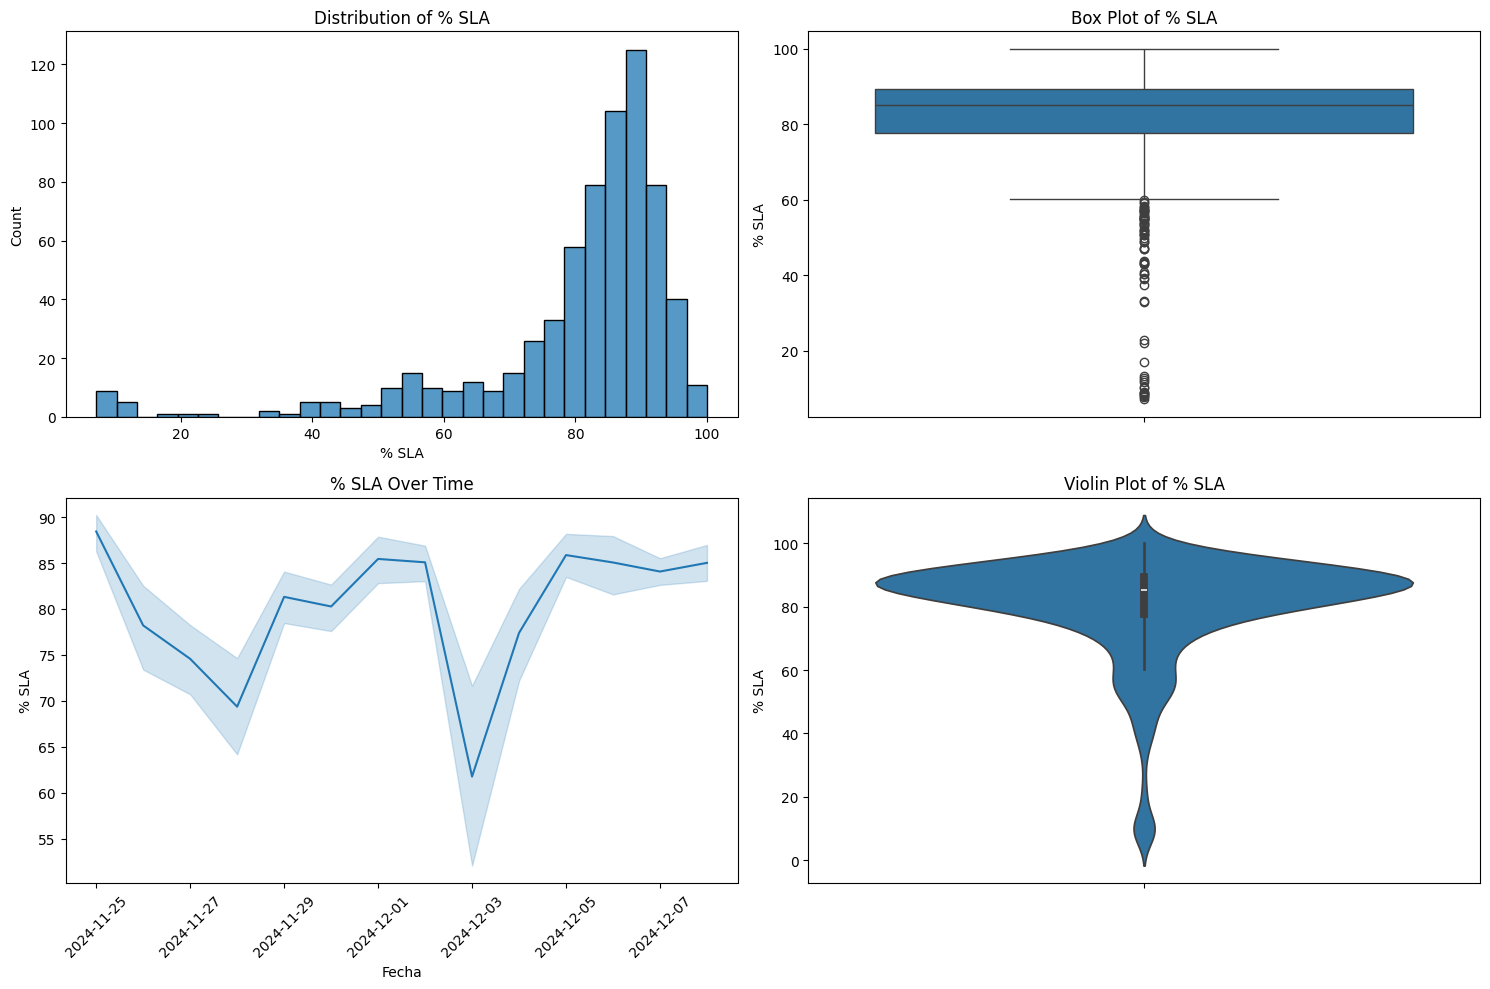


Missing Values:
Count: 0
Percentage: 0.0 %

Top 5 Most Common Values:
% SLA
88.46    7
87.50    7
89.47    6
94.12    6
83.33    6
Name: count, dtype: int64


In [14]:
### %SLA 

# Basic statistics
print("Basic Statistics:")
print(data["% SLA"].describe())

# Additional statistics
print("\nAdditional Statistics:")
print("Skewness:", data["% SLA"].skew())
print("Kurtosis:", data["% SLA"].kurtosis())

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Histogram
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="% SLA", bins=30)
plt.title("Distribution of % SLA")

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=data["% SLA"])
plt.title("Box Plot of % SLA")

# Time series plot (assuming you have a date column)
plt.subplot(2, 2, 3)
sns.lineplot(data=data, x="Fecha", y="% SLA")
plt.title("% SLA Over Time")
plt.xticks(rotation=45)

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=data["% SLA"])
plt.title("Violin Plot of % SLA")

plt.tight_layout()
plt.show()

# Missing values analysis
print("\nMissing Values:")
print("Count:", data["% SLA"].isnull().sum())
print("Percentage:", (data["% SLA"].isnull().sum() / len(data)) * 100, "%")

# Value counts (top 5)
print("\nTop 5 Most Common Values:")
print(data["% SLA"].value_counts().head())

Basic Statistics:
count    672.000000
mean       7.543601
std        1.645967
min        4.280000
25%        6.530000
50%        7.245000
75%        8.175000
max       19.200000
Name: AHT (Min), dtype: float64

Additional Statistics:
Skewness: 2.1168491391167508
Kurtosis: 9.16781504904102


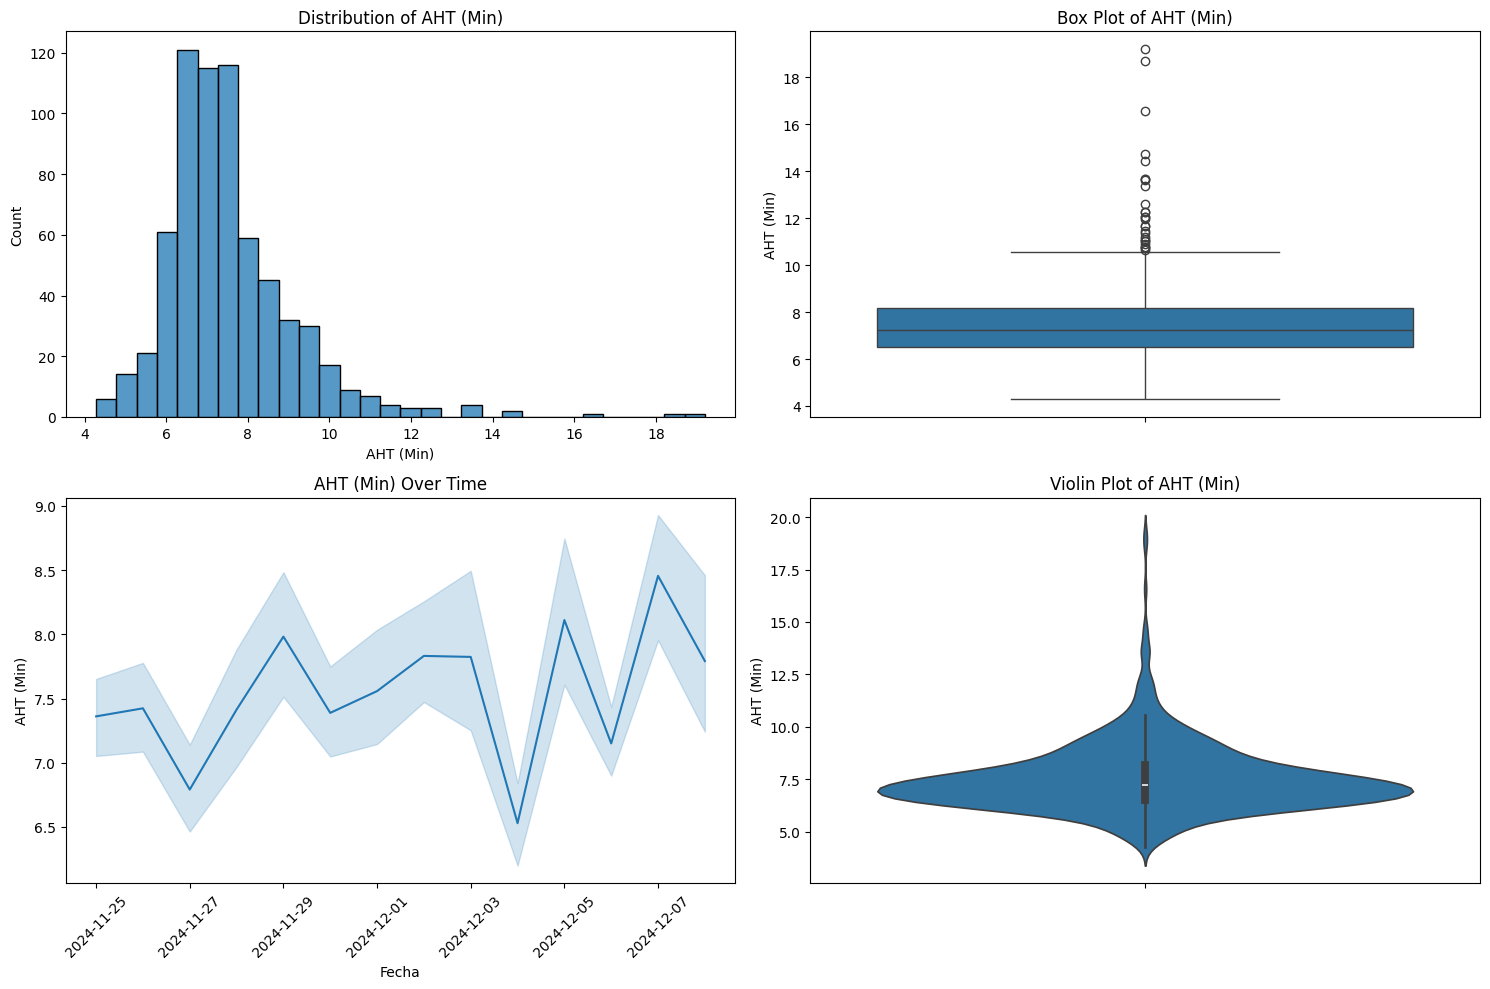


Missing Values:
Count: 0
Percentage: 0.0 %

Top 5 Most Common Values:
% SLA
88.46    7
87.50    7
89.47    6
94.12    6
83.33    6
Name: count, dtype: int64


In [15]:
### AHT (Min)

# Basic statistics
print("Basic Statistics:")
print(data["AHT (Min)"].describe())

# Additional statistics
print("\nAdditional Statistics:")
print("Skewness:", data["AHT (Min)"].skew())
print("Kurtosis:", data["AHT (Min)"].kurtosis())

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# Histogram
plt.subplot(2, 2, 1)
sns.histplot(data=data, x="AHT (Min)", bins=30)
plt.title("Distribution of AHT (Min)")

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=data["AHT (Min)"])
plt.title("Box Plot of AHT (Min)")

# Time series plot (assuming you have a date column)
plt.subplot(2, 2, 3)
sns.lineplot(data=data, x="Fecha", y="AHT (Min)")
plt.title("AHT (Min) Over Time")
plt.xticks(rotation=45)

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=data["AHT (Min)"])
plt.title("Violin Plot of AHT (Min)")

plt.tight_layout()
plt.show()

# Missing values analysis
print("\nMissing Values:")
print("Count:", data["AHT (Min)"].isnull().sum())
print("Percentage:", (data["AHT (Min)"].isnull().sum() / len(data)) * 100, "%")

# Value counts (top 5)
print("\nTop 5 Most Common Values:")
print(data["% SLA"].value_counts().head())

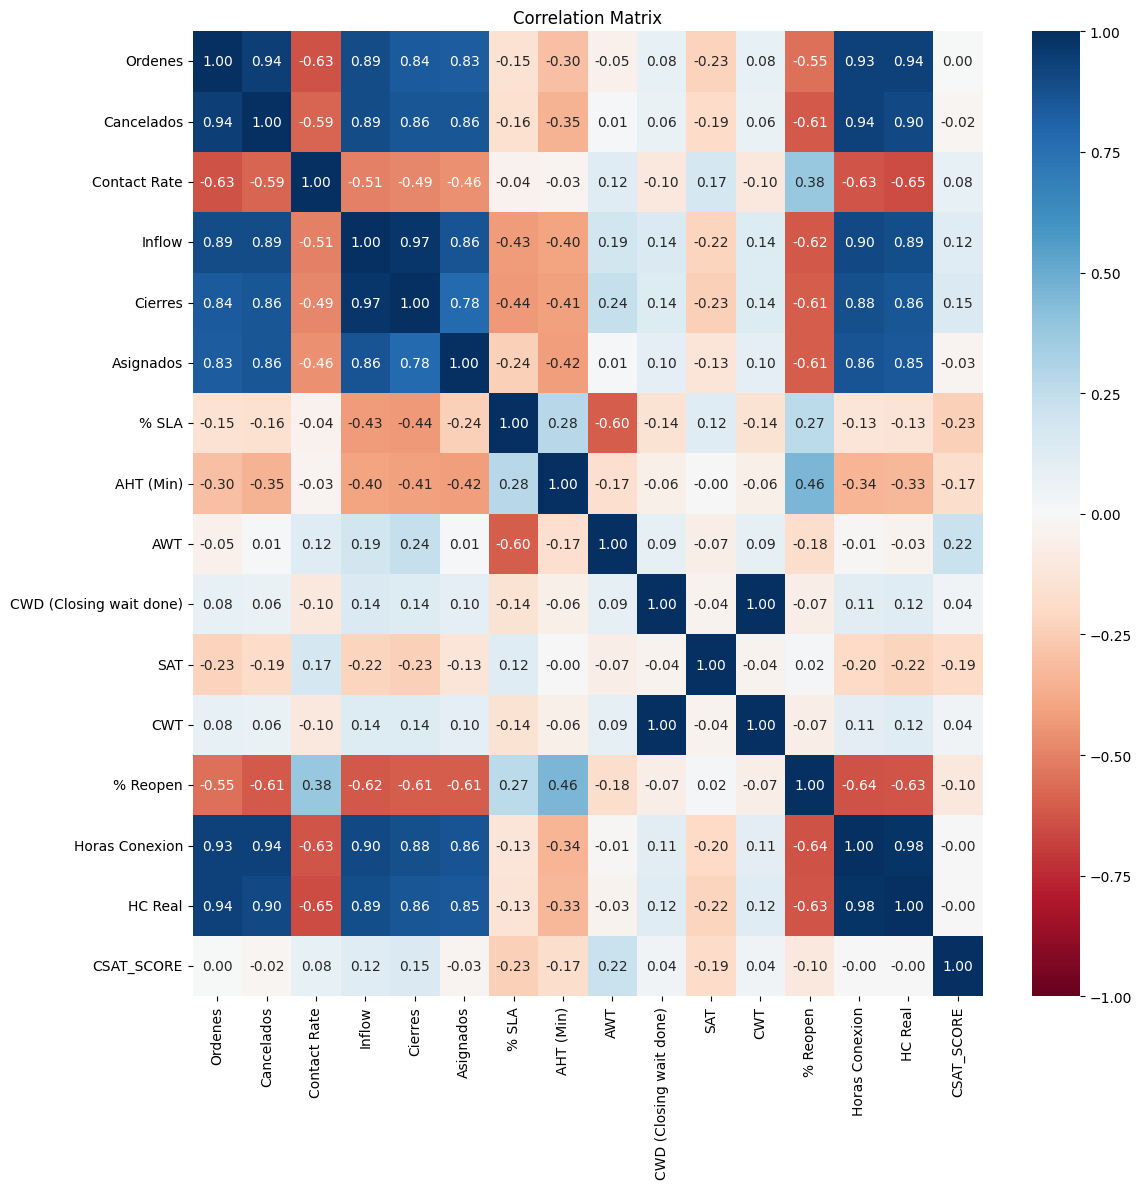

In [17]:
### CORRELATION ANALYSIS

correlation_matrix = data[[
    'Ordenes', 'Cancelados', 'Contact Rate','Inflow', 'Cierres', 'Asignados', '% SLA',
       'AHT (Min)', 'AWT', 'CWD (Closing wait done)',
       'SAT', 'CWT', '% Reopen', 
       'Horas Conexion','HC Real', 'CSAT_SCORE'
    
    
    ]].corr()

# Create a larger figure
plt.figure(figsize=(12, 12))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,            # Show correlation values
            cmap='RdBu',       # Color scheme
            vmin=-1, vmax=1,       # Value range
            center=0,              # Center the colormap at 0
            fmt='.2f')            # Format numbers to 2 decimal places

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


Number of NaN values in each feature:
Inflow       0
Cierres      0
% SLA        0
AHT (Min)    0
AWT          0
dtype: int64

Shape before cleaning: (672, 5)
Shape after cleaning: (672, 5)

Model Performance:
R² Score: -0.0094
RMSE: 9.2047

Feature Importance (Permutation Importance, Ordered from Highest to Lowest):
Inflow: 0.3896 (± 0.0901)
Cierres: 0.1836 (± 0.0999)
AHT (Min): 0.0244 (± 0.0242)
% SLA: 0.0140 (± 0.0221)
AWT: 0.0090 (± 0.0071)


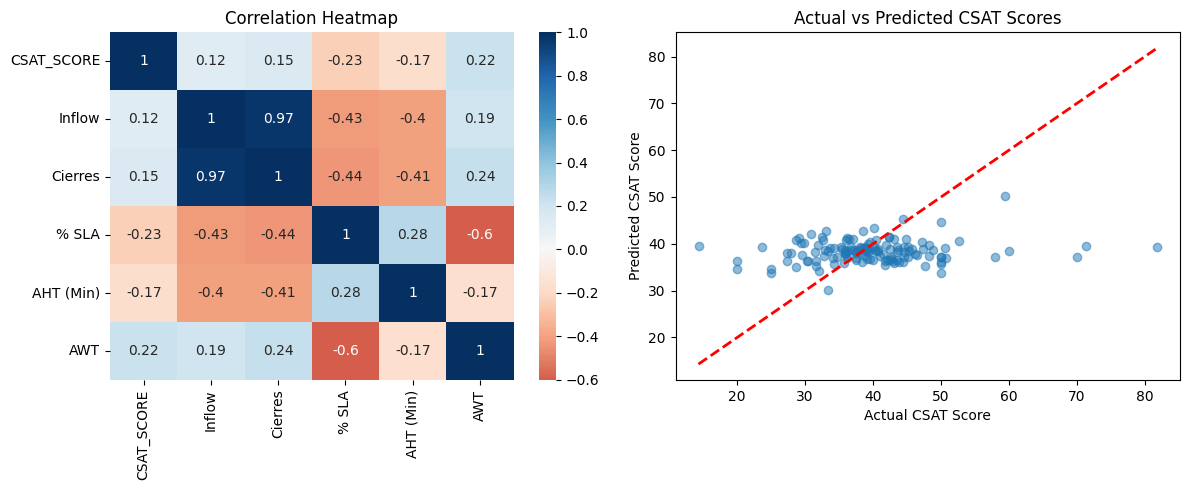

In [69]:
### IMPORTANCE LEVEL (CSAT)

#  Prepare the features and target
X = data[['Inflow', 'Cierres', '% SLA','AHT (Min)', 'AWT']]
y = data['CSAT_SCORE']

# Check for NaN values
print("Number of NaN values in each feature:")
print(X.isna().sum())

# Replace NaN values in X with the median of each column
X_clean = X.fillna(X.median())

print("\nShape before cleaning:", X.shape)
print("Shape after cleaning:", X_clean.shape)

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Calculate Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Feature Importance sorted by permutation importance (highest to lowest)
print("\nFeature Importance (Permutation Importance, Ordered from Highest to Lowest):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
for _, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f} (± {row['Std']:.4f})")

# Create visualization
plt.figure(figsize=(12, 5))

# Correlation heatmap
plt.subplot(1, 2, 1)
correlation_matrix = data[['CSAT_SCORE', 'Inflow', 'Cierres', '% SLA','AHT (Min)', 'AWT']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')

# Actual vs Predicted plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CSAT Score')
plt.ylabel('Predicted CSAT Score')
plt.title('Actual vs Predicted CSAT Scores')

plt.tight_layout()
plt.show()

Number of NaN values in each feature:
Inflow        0
% Reopen     72
AHT (Min)     0
AWT           0
dtype: int64

Shape before cleaning: (672, 4)
Shape after cleaning: (672, 4)

Model Performance:
R² Score: 0.4125
RMSE: 9.8533

Feature Importance (Permutation Importance, Ordered from Highest to Lowest):
AWT: 0.4277 (± 0.0536)
Inflow: 0.2458 (± 0.0463)
% Reopen: 0.0179 (± 0.0085)
AHT (Min): 0.0074 (± 0.0113)


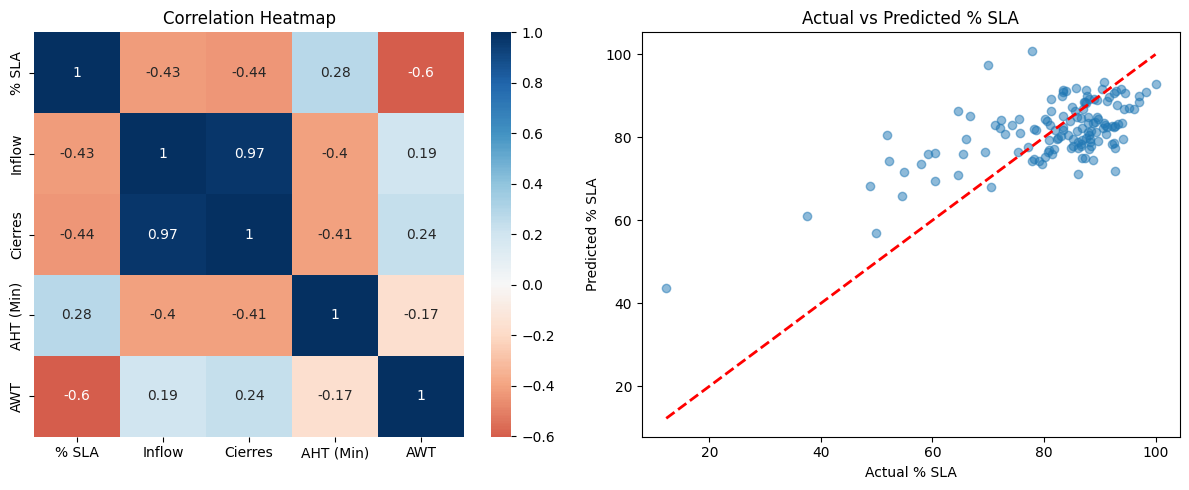

In [73]:
### IMPORTANCE LEVEL (SLA)

#  Prepare the features and target
X = data[['Inflow', '% Reopen','AHT (Min)', 'AWT']]
y = data['% SLA']

# Check for NaN values
print("Number of NaN values in each feature:")
print(X.isna().sum())

# Replace NaN values in X with the median of each column
X_clean = X.fillna(X.median())

print("\nShape before cleaning:", X.shape)
print("Shape after cleaning:", X_clean.shape)

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Calculate Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Feature Importance sorted by permutation importance (highest to lowest)
print("\nFeature Importance (Permutation Importance, Ordered from Highest to Lowest):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
for _, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f} (± {row['Std']:.4f})")

# Create visualization
plt.figure(figsize=(12, 5))

# Correlation heatmap
plt.subplot(1, 2, 1)
correlation_matrix = data[['% SLA', 'Inflow', 'Cierres','AHT (Min)', 'AWT']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')

# Actual vs Predicted plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual % SLA')
plt.ylabel('Predicted % SLA')
plt.title('Actual vs Predicted % SLA')

plt.tight_layout()
plt.show()

Number of NaN values in each feature:
Inflow             0
% Reopen          72
Horas Conexion     0
AWT                0
Cierres            0
Cancelados         0
Ordenes            0
HC Real            0
dtype: int64

Shape before cleaning: (672, 8)
Shape after cleaning: (672, 8)

Model Performance:
R² Score: 0.3147
RMSE: 1.4202

Feature Importance (Permutation Importance, Ordered from Highest to Lowest):
Inflow: 0.2736 (± 0.0542)
HC Real: 0.2318 (± 0.0583)
Ordenes: 0.2044 (± 0.0458)
% Reopen: 0.1896 (± 0.0332)
Horas Conexion: 0.1724 (± 0.0495)
Cancelados: 0.1140 (± 0.0312)
Cierres: 0.0495 (± 0.0191)
AWT: 0.0003 (± 0.0002)


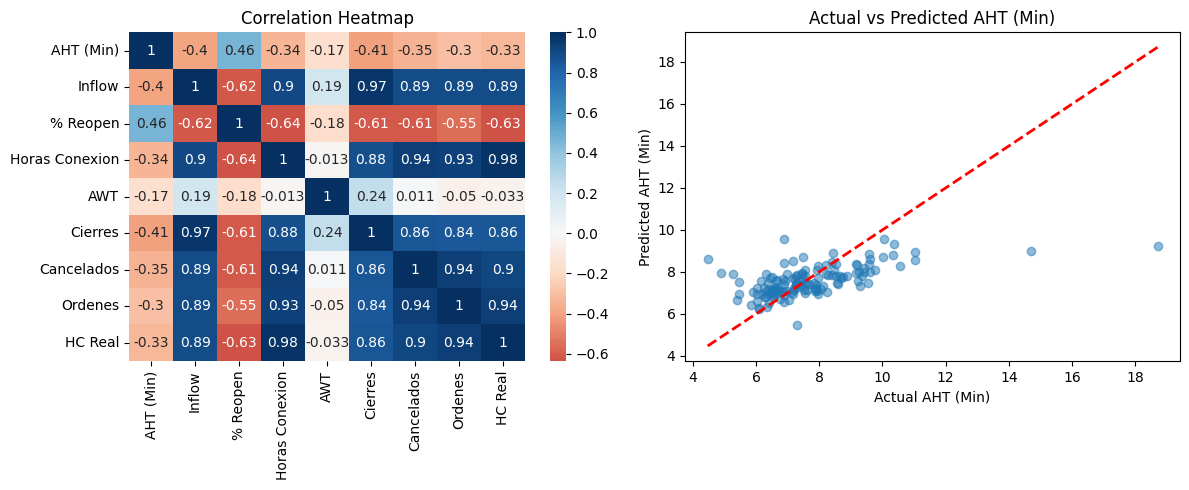

In [74]:
### IMPORTANCE LEVEL (AHT (Min))

#  Prepare the features and target
X = data[['Inflow', '% Reopen','Horas Conexion', 'AWT', 'Cierres', 'Cancelados', 'Ordenes', 'HC Real']]
y = data['AHT (Min)']

# Check for NaN values
print("Number of NaN values in each feature:")
print(X.isna().sum())

# Replace NaN values in X with the median of each column
X_clean = X.fillna(X.median())

print("\nShape before cleaning:", X.shape)
print("Shape after cleaning:", X_clean.shape)

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("\nModel Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Calculate Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Feature Importance sorted by permutation importance (highest to lowest)
print("\nFeature Importance (Permutation Importance, Ordered from Highest to Lowest):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
for _, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f} (± {row['Std']:.4f})")

# Create visualization
plt.figure(figsize=(12, 5))

# Correlation heatmap
plt.subplot(1, 2, 1)
correlation_matrix = data[['AHT (Min)', 'Inflow', '% Reopen','Horas Conexion', 'AWT', 'Cierres', 'Cancelados', 'Ordenes', 'HC Real']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')

# Actual vs Predicted plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AHT (Min)')
plt.ylabel('Predicted AHT (Min)')
plt.title('Actual vs Predicted AHT (Min)')

plt.tight_layout()
plt.show()

RANDOM FOREST BY CSAT SCORE, SLA & AHT (TARGETS)

In [ ]:
### CSAT SCORE

# Prepare the data
X = data[[ 'Inflow', 'Cierres', '% SLA','AHT (Min)', 'AWT']]
y = data['CSAT_SCORE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create base model
rf_base = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Find best parameters
grid_search.fit(X_train, y_train)

# Use best model
rf_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_model, X, y, cv=5)

# Train final model and make predictions
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Find optimal ranges when AHT <= Target
optimal_ranges = {}
Target = 75.0
mask = y >= Target  
for feature in X.columns:
    optimal_ranges[feature] = {
        'min': X[mask][feature].quantile(0.05),
        'max': X[mask][feature].quantile(0.95)
    }

# Print results
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Model evaluation
print("\nModel Quality Assessment:")
if r2 >= 0.7:
    print("✓ Model is GOOD (R² >= 0.7)")
    if r2 >= 0.9:
        print("✓ Model is EXCELLENT (R² >= 0.9)")
else:
    print("✗ Model needs improvement (R² < 0.7)")

if rmse < 0.5:
    print("✓ Prediction error is acceptable (RMSE < 0.5)")
else:
    print("✗ High prediction error (RMSE >= 0.5)")

if cv_scores.std() < 0.1:
    print("✓ Model is stable across different data splits")
else:
    print("✗ Model performance varies significantly across different data splits")

print("\nFeature Importance:")
print(feature_importance)

print(f"\nOptimal ranges for % CSAT SCORE >= {Target}:")
for feature, ranges in optimal_ranges.items():
    print(f"{feature}: {ranges['min']:.2f} - {ranges['max']:.2f}")

Best Parameters Found:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

Model Performance Metrics:
R² Score: -0.184
Root Mean Square Error (RMSE): 9.969
Mean Absolute Error (MAE): 6.595

Cross-validation scores: [-0.27379632 -0.14488284 -0.11527016 -0.09707275 -0.05825965]
Mean CV score: -0.138 (+/- 0.147)

Model Quality Assessment:
✗ Model needs improvement (R² < 0.7)
✗ High prediction error (RMSE >= 0.5)
✓ Model is stable across different data splits

Feature Importance:
     feature  importance
2      % SLA    0.346444
0     Inflow    0.207770
3  AHT (Min)    0.202531
1    Cierres    0.125768
4        AWT    0.117487

Optimal ranges for % CSAT SCORE >= 75.0:
Inflow: 22.90 - 39.10
Cierres: 63.35 - 87.65
% SLA: 82.35 - 91.97
AHT (Min): 4.44 - 7.28
AWT: 27.12 - 27.39


In [72]:
### % SLA

# Prepare the data
X = data[[ '% Reopen', 'AWT', 'Inflow']]
y = data['% SLA']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create base model
rf_base = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Find best parameters
grid_search.fit(X_train, y_train)

# Use best model
rf_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_model, X, y, cv=5)

# Train final model and make predictions
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Find optimal ranges when AHT <= Target
optimal_ranges = {}
Target = 90.0
mask = y >= Target  
for feature in X.columns:
    optimal_ranges[feature] = {
        'min': X[mask][feature].quantile(0.05),
        'max': X[mask][feature].quantile(0.95)
    }

# Print results
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Model evaluation
print("\nModel Quality Assessment:")
if r2 >= 0.7:
    print("✓ Model is GOOD (R² >= 0.7)")
    if r2 >= 0.9:
        print("✓ Model is EXCELLENT (R² >= 0.9)")
else:
    print("✗ Model needs improvement (R² < 0.7)")

if rmse < 0.5:
    print("✓ Prediction error is acceptable (RMSE < 0.5)")
else:
    print("✗ High prediction error (RMSE >= 0.5)")

if cv_scores.std() < 0.1:
    print("✓ Model is stable across different data splits")
else:
    print("✗ Model performance varies significantly across different data splits")

print("\nFeature Importance:")
print(feature_importance)

print(f"\nOptimal ranges for % SLA >= {Target}:")
for feature, ranges in optimal_ranges.items():
    print(f"{feature}: {ranges['min']:.2f} - {ranges['max']:.2f}")

Best Parameters Found:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

Model Performance Metrics:
R² Score: 0.570
Root Mean Square Error (RMSE): 8.433
Mean Absolute Error (MAE): 6.375

Cross-validation scores: [ 0.39474797  0.22564043 -0.17557748  0.52778347 -0.51176104]
Mean CV score: 0.092 (+/- 0.767)

Model Quality Assessment:
✗ Model needs improvement (R² < 0.7)
✗ High prediction error (RMSE >= 0.5)
✗ Model performance varies significantly across different data splits

Feature Importance:
    feature  importance
1       AWT     0.51697
2    Inflow     0.39660
0  % Reopen     0.08643

Optimal ranges for % SLA >= 90.0:
% Reopen: 15.38 - 107.56
AWT: 0.04 - 16.49
Inflow: 19.45 - 497.80


In [76]:
#### AHT (min)

# Prepare the data
X = data[['Inflow', '% Reopen','Horas Conexion', 'AWT', 'Cierres', 'Cancelados', 'Ordenes', 'HC Real']]
y = data['AHT (Min)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create base model
rf_base = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Find best parameters
grid_search.fit(X_train, y_train)

# Use best model
rf_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_model, X, y, cv=5)

# Train final model and make predictions
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Find optimal ranges when AHT <= Target
optimal_ranges = {}
Target = 7.0
mask = y <= Target  
for feature in X.columns:
    optimal_ranges[feature] = {
        'min': X[mask][feature].quantile(0.05),
        'max': X[mask][feature].quantile(0.95)
    }

# Print results
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Model evaluation
print("\nModel Quality Assessment:")
if r2 >= 0.7:
    print("✓ Model is GOOD (R² >= 0.7)")
    if r2 >= 0.9:
        print("✓ Model is EXCELLENT (R² >= 0.9)")
else:
    print("✗ Model needs improvement (R² < 0.7)")

if rmse < 0.5:
    print("✓ Prediction error is acceptable (RMSE < 0.5)")
else:
    print("✗ High prediction error (RMSE >= 0.5)")

if cv_scores.std() < 0.1:
    print("✓ Model is stable across different data splits")
else:
    print("✗ Model performance varies significantly across different data splits")

print("\nFeature Importance:")
print(feature_importance)

print(f"\nOptimal ranges for AHT (Min) <= {Target}:")
for feature, ranges in optimal_ranges.items():
    print(f"{feature}: {ranges['min']:.2f} - {ranges['max']:.2f}")

Best Parameters Found:
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

Model Performance Metrics:
R² Score: 0.477
Root Mean Square Error (RMSE): 1.178
Mean Absolute Error (MAE): 0.813

Cross-validation scores: [-1.22602782  0.43224367  0.4172793   0.29077668  0.35343551]
Mean CV score: 0.054 (+/- 1.284)

Model Quality Assessment:
✗ Model needs improvement (R² < 0.7)
✗ High prediction error (RMSE >= 0.5)
✗ Model performance varies significantly across different data splits

Feature Importance:
          feature  importance
4         Cierres    0.312994
1        % Reopen    0.211478
0          Inflow    0.115445
3             AWT    0.087523
6         Ordenes    0.086521
5      Cancelados    0.076022
2  Horas Conexion    0.062477
7         HC Real    0.047539

Optimal ranges for AHT (Min) <= 7.0:
Inflow: 29.20 - 713.70
% Reopen: 8.38 - 75.51
Horas Conexion: 18.04 - 114.48
AWT: 0.75 - 50.32
Cierres: 49.10 - 502.60
Cancelados: 46.00 - 1467.90
Ordenes: 335.70 - 32980.50
H